<a href="https://colab.research.google.com/github/jumbokh/ML-Class/blob/main/notebooks/9_1_%E8%A6%96%E8%A6%BA%E5%8C%96%E9%80%B2%E5%87%BA%E5%A0%B4%E7%AD%96%E7%95%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 視覺化進出場策略 (Visualizing Strategies)

In [ ]:
# 將需要的模組放入 colab 中
!wget https://github.com/victorgau/python_investment/raw/master/backtest.py -o /dev/null

In [ ]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 10.9 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24109 sha256=ec23c89a24f5c6ec51942eb5f7a60f045cad70d4147054a365dfda59515d7663
  Stored in directory: /root/.cache/pip/wheels/86/fe/9b/a4d3d78796b699e37065e5b6c27b75cff448ddb8b24943c288
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


## 看一下單一股票的進出場狀況

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import backtest

In [ ]:
import yfinance as yf

## 讀取歷史股價

In [ ]:
start = "2017-01-01"
end = "2017-12-31"

In [ ]:
# 讀取從指定日期之後的股價資訊
df = yf.download('TSLA', start, end)

[*********************100%***********************]  1 of 1 completed


## 訂定策略

In [ ]:
# 突破策略
def breakout(df):
    # Donchian Channel
    df['20d_high'] = pd.Series.rolling(df['Adj Close'], window=20).max()
    df['10d_low'] = pd.Series.rolling(df['Adj Close'], window=10).min()

    has_position = False
    df['signals'] = 0
    for t in range(1, df['signals'].size):
        # 進場條件
        if df['Adj Close'][t] > df['20d_high'][t-1]:
            if not has_position:
                df.loc[df.index[t], 'signals'] = 1
                has_position = True
        # 出場條件
        elif df['Adj Close'][t] < df['10d_low'][t-1]:
            if has_position:
                df.loc[df.index[t], 'signals'] = -1
                has_position = False

    df['positions'] = df['signals'].cumsum().shift()

In [ ]:
def macross(df):
    # 均線
    df['20d'] = pd.Series.rolling(df['Adj Close'], window=20).mean()
    df['60d'] = pd.Series.rolling(df['Adj Close'], window=60).mean()
    
    has_position = False
    df['signals'] = 0
    for t in range(1, df['signals'].size):
        # 進場條件
        if df['20d'][t] > df['60d'][t] and df['20d'][t-1] < df['60d'][t-1] and df['60d'][t] > df['60d'][t-1]:
            if not has_position:
                df.loc[df.index[t], 'signals'] = 1
                has_position = True
        # 出場條件
        elif df['Adj Close'][t] < df['60d'][t] and df['Adj Close'][t-1] < df['60d'][t-1]:
            if has_position:
                df.loc[df.index[t], 'signals'] = -1
                has_position = False

    df['positions'] = df['signals'].cumsum().shift()

In [ ]:
strategy = breakout
strategy(df)

In [ ]:
np.where(df['signals']==1)

(array([ 23,  56,  88, 101, 147, 175, 237]),)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f207bd9e110>,
      dtype=object)

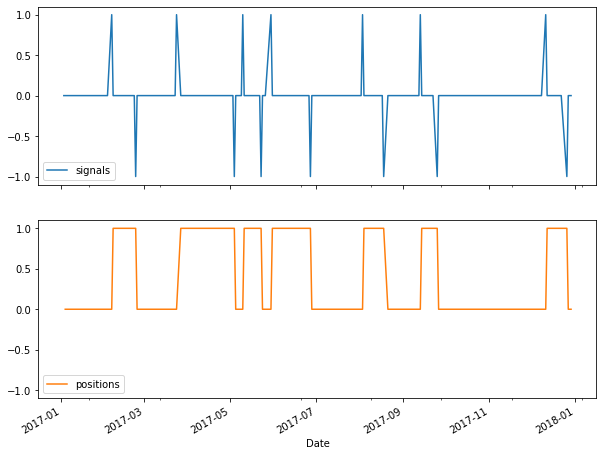

In [ ]:
# 底下這一行只是為了要在下面把 signals 跟 positions 畫出來做說明用
df[['signals', 'positions']].plot(subplots = True, ylim=(-1.1, 1.1), figsize = (10, 8))

## 標出進出場點

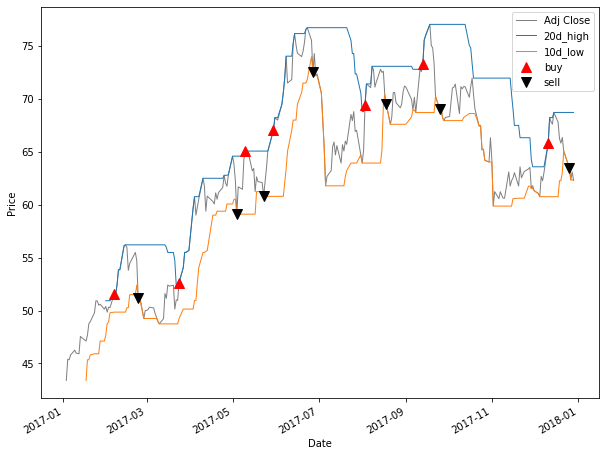

In [ ]:
fig, ax = plt.subplots()

ax.set_ylabel('Price')

# lines = ['60d', '20d']
lines = ['20d_high', '10d_low']

df['Adj Close'].plot(ax=ax, color='gray', lw=1., figsize=(10,8))
for i in lines:
    df[i].plot(ax=ax, lw=1., label=i)

# Plot the "buy" trades
ax.plot(df.loc[df.signals == 1].index,df['Adj Close'][df.signals == 1],'^', markersize=10, color='r', label='buy')

# Plot the "sell" trades
ax.plot(df.loc[df.signals == -1].index, df['Adj Close'][df.signals == -1], 'v', markersize=10, color='k', label='sell')

plt.legend()

## 計算Sharpe Ratio

In [ ]:
dailyRet = df['Adj Close'].pct_change()

In [ ]:
#假設無風險利率為 4%
#假設一年有252個交易日
excessRet = np.where(df['positions']==1, dailyRet, 0) - 0.04/252

sharpeRatio = np.sqrt(252.0)*np.mean(excessRet)/np.std(excessRet)

In [ ]:
sharpeRatio

0.04135209002310065

## 計算MaxDD跟MaxDDD

In [ ]:
df['Ret'] = np.where(df['positions']==1, dailyRet, 0)
cumRet = np.cumprod(1 + df['Ret'])

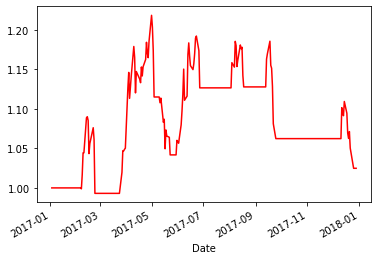

In [ ]:
cumRet.plot(style='r-')

In [ ]:
backtest.DrawDownAnalysis(cumRet)

(-0.15881114679586705, 241)